In [219]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import warnings
import random
random.seed(42)
warnings.filterwarnings('ignore')

In [220]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.stats import kurtosis
from pmdarima.arima import auto_arima


In [221]:
import os
import sys
module_path = os.path.abspath(os.path.join('.'))
# from utils import eval_metrics

In [222]:
sales = pd.read_csv('Dataset/train.csv')
sales.Date = pd.to_datetime(sales.Date)
sales.reset_index()
sales['Date'] = sales['Date'].astype('datetime64')
sales.set_index('Date', inplace=True)
sales.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
Date,,,,,,,,
2015-07-31,1,5,5263,555,1,1,0,1
2015-07-31,2,5,6064,625,1,1,0,1
2015-07-31,3,5,8314,821,1,1,0,1
2015-07-31,4,5,13995,1498,1,1,0,1
2015-07-31,5,5,4822,559,1,1,0,1


# Baseline Model

In [279]:
# Requirement : Index must be sorted in ascending order
def BaselinePrediction(data, predict_timeframe= 0, window = 12):
    timeframe_predictions = None
    if(predict_timeframe > 0):
        val = pd.date_range(data.index[-1] + pd.Timedelta(days = 1), periods= predict_timeframe, freq= 'D')
        pred_values = list(data.iloc[-window:].values)
        for i in np.arange(1,predict_timeframe):
            pred_values.append(np.sum(pred_values[-window:])/window)
        timeframe_predictions = pd.Series(index= val, data= pred_values[-predict_timeframe:]) 
        timeframe_predictions.fillna(0,inplace=True)   
        plt.plot(timeframe_predictions, color = 'red', label= "Test Predictions")   
    predictions = data.rolling(window).mean()
    predictions.fillna(0, inplace = True)
    plt.plot(data,color = '#000000', label = 'Original Data')
    plt.plot(predictions, color = 'orange', label = 'Train Predictions')
    plt.legend()
    return predictions

In [280]:
def eval_metrics(actual_val, predicted_val):
    """
    Returns the MSE, MAE and RMSE Error for the given values
    Parameters:
    * actual_val    : The actual value of the data
    * predicted_val : The predicted value of the data
    returns:
    errors<Tuple> : A tuple of MSE MAE and RMSE score for the data (MSE, MAE, RMSE)
    """
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    import seaborn as sns
    import plotly.express as px
    import warnings
    import random
    mse     = (np.square(actual_val - predicted_val)).mean()
    mae     = (np.abs(actual_val - predicted_val)).mean()
    rmse    = np.sqrt(mse)
    errors  = (mse,mae,rmse)
    return errors


# Predictions


### For Store Number(1)

In [281]:
print(random.randint(1, 1555))
first_store = sales[sales['Store'] == 1]
first_store_open = first_store[first_store.Open ==1]
# first_store.index= first_store.index.astype('datetime64[ns]')
fs = first_store.Sales.copy()
fs.sort_index(ascending= True, inplace= True)

1117


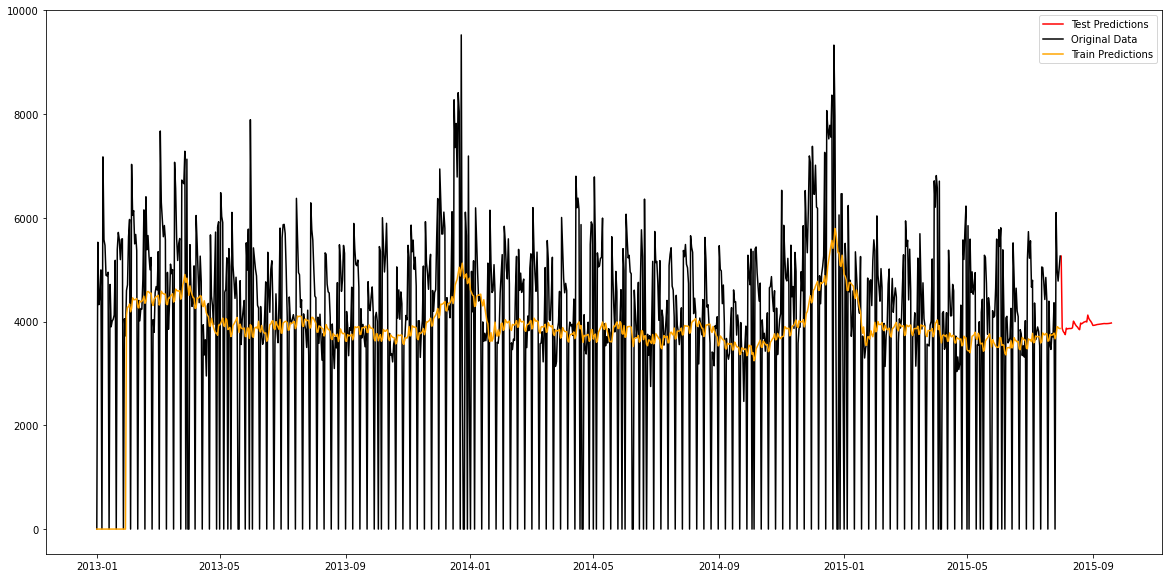

In [283]:
predict_timeframe = 50
window = 30
data = fs
plt.figure(figsize=(20,10))
predict_1 = BaselinePrediction(fs, predict_timeframe=predict_timeframe, window=window)
# plt.plot(fs)

In [227]:
eval_metrics(predict_1, fs)

(3974608.969892674, 1459.3508492569, 1993.642136867265)

### Taking the Mean of the data as the baseline model

In [228]:
def SimpleMeanBaseline(data, title= "hello" ,  mean_line = True, xlabel="time", ylabel="series"):
    plt.figure(figsize =(10 ,7))

    predictions = pd.Series([ np.nanmean(data) ]* len(fs) , index = fs.index)   
    plt.plot(data)
    if(mean_line  == True):
        plt.axhline(y=np.nanmean(data), color = "red", label = f'mean(= {np.nanmean(data):.2f} )')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.xticks(rotation=45 , rotation_mode='anchor', ha ='right' )
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show();
    return predictions

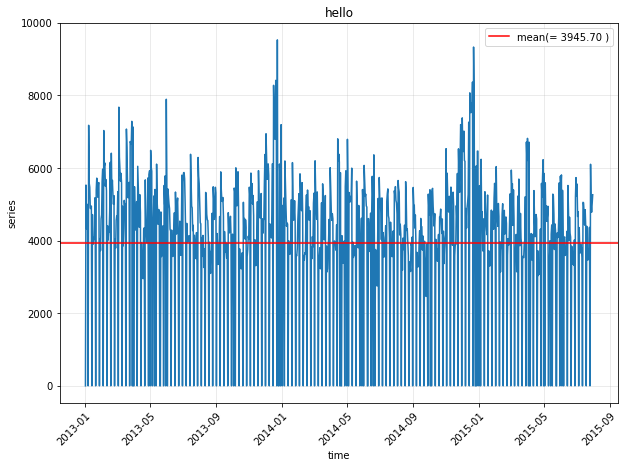

Date
2013-01-01    3945.704883
2013-01-02    3945.704883
2013-01-03    3945.704883
2013-01-04    3945.704883
2013-01-05    3945.704883
                 ...     
2015-07-27    3945.704883
2015-07-28    3945.704883
2015-07-29    3945.704883
2015-07-30    3945.704883
2015-07-31    3945.704883
Length: 942, dtype: float64

In [229]:
SimpleMeanBaseline(fs)

In [230]:
predictions = pd.Series([ np.nanmean(data) ]* len(fs) , index = fs.index)
predictions

Date
2013-01-01    3945.704883
2013-01-02    3945.704883
2013-01-03    3945.704883
2013-01-04    3945.704883
2013-01-05    3945.704883
                 ...     
2015-07-27    3945.704883
2015-07-28    3945.704883
2015-07-29    3945.704883
2015-07-30    3945.704883
2015-07-31    3945.704883
Length: 942, dtype: float64

In [231]:
# for i in np.arange(1,10):
#     fs[fs.index[-1] + pd.Timedelta(days = i)] = np.NaN()
# fs

In [232]:
# fs[fs.index[-1] + pd.Timedelta(days = 3)].loc['Sales'] = 0